In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir('/content/gdrive/My Drive/ImageCaptioning')
#!ls

In [0]:
#!pip install Merge

In [3]:
# from keras.layers import Merge
from keras.layers import Concatenate

Using TensorFlow backend.


In [0]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

In [0]:
token = 'Flickr8k_text/Flickr8k.token.txt'

In [0]:
captions = open(token, 'r').read().strip().split('\n')

In [0]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [8]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [0]:
#images = './Flickr8k_Dataset/Flicker8k_Dataset/*.jpg'

In [0]:
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'

In [0]:
img = glob.glob(images+'*.jpg')


In [0]:
#img = glob.glob('./Flickr8k_Dataset/Flicker8k_Dataset/*.jpg')

In [12]:
img[:5]

['Flickr8k_Dataset/Flicker8k_Dataset/2302516347_26054442f9.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/2219959872_988e6d498e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3287969199_08e775d896.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/3667318593_fa1816b346.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset/229978782_3c690f5a0e.jpg']

In [0]:
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'

In [14]:
len(train_images_file)

39

In [0]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [16]:
len(train_images)

6000

In [0]:
#train_images = pd.read_csv('Flickr8k_text/Flickr_8k.trainImages.txt', delimiter='\t')

In [0]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [19]:
len(images)

35

In [20]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [0]:
val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [22]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [0]:
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [24]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

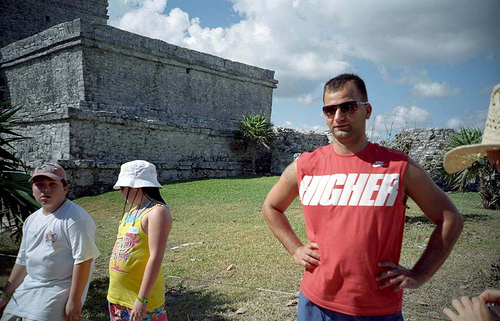

In [25]:
Image.open(train_img[0])

In [0]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [0]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


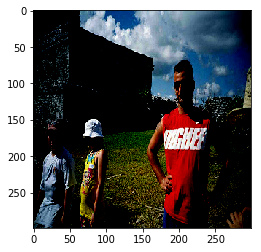

In [28]:
plt.imshow(np.squeeze(preprocess(train_img[0])))


In [29]:
model = InceptionV3(weights='imagenet')









96116736/96112376 [==============================] - 4s 0us/step


In [0]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [0]:
tryi = model_new.predict(preprocess(train_img[0]))

In [32]:
tryi.shape

(1, 2048)

In [0]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [34]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

100%|██████████| 6000/6000 [54:11<00:00,  2.07it/s]


In [0]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [0]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [37]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [38]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [08:54<00:00,  2.04it/s]


In [0]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [0]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [41]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [0]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [43]:

len(train_d)

6000

In [44]:

train_d[images+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [0]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [0]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [47]:
len(test_d)

1000

calculating unique words in vocabulary


In [0]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [0]:
words = [i.split() for i in caps]


In [0]:
unique = []
for i in words:
    unique.extend(i)

In [0]:
unique = list(set(unique))

In [0]:
with open("unique.p", "wb") as pickle_d:
  pickle.dump(unique, pickle_d)

In [0]:
unique = pickle.load(open('unique.p', 'rb'))

In [54]:
len(unique)

8256

In [0]:
word2idx = {val:index for index, val in enumerate(unique)}

In [56]:
word2idx['<start>']

4270

In [0]:
idx2word = {index:val for index, val in enumerate(unique)}

In [58]:
idx2word[5553]

'prepared'

In [59]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [60]:
len(unique), max_len


(8256, 40)

In [0]:
vocab_size = len(unique)

In [62]:
vocab_size

8256

In [63]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [0]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [0]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')


In [66]:
df

,image_id,captions
0,2219959872_988e6d498e.jpg,<start> A man and two kids standing in front o...
1,2219959872_988e6d498e.jpg,<start> A man in a red muscle shirt poses for ...
2,2219959872_988e6d498e.jpg,<start> A man in a red shirt is standing with ...
3,2219959872_988e6d498e.jpg,<start> A man poses outside a tourist location...
4,2219959872_988e6d498e.jpg,<start> A man wearing a sleeveless shirt and s...
5,3667318593_fa1816b346.jpg,<start> A girl in a dress sitting on a red swi...
6,3667318593_fa1816b346.jpg,<start> a girl sits on a swing ride . <end>
7,3667318593_fa1816b346.jpg,<start> A small Asian girl is sitting in a red...
8,3667318593_fa1816b346.jpg,<start> The girl is sitting on a swing . <end>
9,3667318593_fa1816b346.jpg,<start> The young girl is sitting on the swing...


In [67]:
len(df)

30000

In [68]:
c = [i for i in df['captions']]
len(c)

30000

In [0]:
imgs = [i for i in df['image_id']]

In [70]:
a = c[-1]
a, imgs[-1]

('<start> Helmeted boy bicyclist on path in the woods . <end>',
 '608257195_6ec6f48e37.jpg')

In [71]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 4270
Helmeted => 6053
boy => 805
bicyclist => 2860
on => 3910
path => 7926
in => 1576
the => 3467
woods => 1217
. => 7070
<end> => 6594


In [0]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [73]:
samples_per_epoch

383454

In [0]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0


In [0]:
embedding_size = 300
image_model = Sequential([Dense(embedding_size, input_shape=(2048,), activation='relu'),RepeatVector(max_len)])
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

In [0]:

from keras.layers import concatenate
concat_layers = concatenate([image_model.output, caption_model.output])
layer = Bidirectional(LSTM(256, return_sequences=False))(concat_layers)
layer = Dense(vocab_size)(layer)
outlayer = Activation('softmax')(layer)
final_model = Model([image_model.input, caption_model.input], [outlayer])

In [80]:

# final_model = Sequential([
#         merge([image_model, caption_model], mode='concat', concat_axis=1),
#         Bidirectional(LSTM(256, return_sequences=False)),
#         Dense(vocab_size),
#         Activation('softmax')
# ])
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
# checkpoint = ModelCheckpoint('weights.h5', monitor='val_acc',save_best_only=True, verbose=2), early_stopping = EarlyStopping(monitor="val_loss", patience=5)

# merged_model.fit([x1, x2], y=y, batch_size=384, epochs=200,
#              verbose=1, validation_split=0.1, shuffle=True, 
# callbacks=[early_stopping, checkpoint])
# final_model.summary()
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, verbose=1)
final_model.save_weights('time_inceptionV3_7_loss_3.2604.h5')
final_model.load_weights('time_inceptionV3_1.5987_loss.h5')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, steps_per_epoch=383454, epochs=1)`
  


Epoch 1/1
 89337/383454 [=====>........................] - ETA: 24:02:20 - loss: 3.1876 - acc: 0.4525

KeyboardInterrupt: ignored

In [0]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption
try_image = test_img[0]
print(try_image)
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

In [0]:
#image_model = Sequential()
#image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu', RepeatVector = max_len))

In [0]:
'''image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])'''

In [0]:
#caption_model = Sequential()
#caption_model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
#caption_model = LSTM(256, return_sequences=True)
#caption_model = TimeDistributed(Dense(300))

In [0]:
'''caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])'''

In [0]:
#import keras

In [0]:
final_model.summary()

In [0]:
'''final_model = Sequential([
        Concatenate([image_model, caption_model]),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])'''

In [0]:
#final_model = Sequential()
#final_model.add(Concatenate([image_model, caption_model]))
#final_model.add(Dense(vocab_size,activation ='softmax'))
#final_model.add(Bidirectional(LSTM(256, return_sequences=False))
#final_model.add(Dense(vocab_size, activation = 'softmax'))

In [0]:
#F = Model(inputs=[image_model, caption_model], outputs=final_model)

In [0]:
#final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])


In [0]:
# image_model = Sequential()
# image_model.add(Dense(embedding_size,  input_shape=(2048,), activation='softmax'))

# #512 hidden units in LSTM layer. 300-dimensional word vectors.
# caption_model = Sequential()
# caption_model.add( Embedding(vocab_size, embedding_size, input_length=max_len))
# caption_model.add(LSTM(256, return_sequences=True, input_shape = (max_len,300)))



In [0]:
# final_model = Sequential()
# final_model.add(Concatenate([image_model, caption_model]))
# #model = Merge([image_model, caption_model], mode='concat', concat_axis=1)
# #final_model.add(Concatenate([image_model, caption_model]))
# final_model.add(Dense(vocab_size,activation ='softmax'))
# final_model.add(LSTM(256, return_sequences=False))
# final_model.add(Dense(vocab_size, activation = 'softmax'))



In [0]:
# final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])


In [0]:
#final_model.summary()